# Negative Power Functions

## Overview

Now that we have considered the quantum linear system problem (QLSP), it is natural to consider the following generalization: given access to an invertible matrix A and a normalized quantum state $|b\rangle$, we want to construct a quantum state
$$ |x\rangle := \frac{A^{-c} |b\rangle}{\| A^{-c} |b\rangle \|_2}, $$
where $c$ is an integer larger than 1. The implementation boils down to a scalar function $f(x) = x^{-c}$. Without loss of generality, we assume the matrix is normalized. As before, we want a polynomial with parity approximating $f(x)$ over the interval $D_\kappa := [-1,-\kappa] \cup [-\kappa,1]$.

## Setup

Just as with QLSP, we will let $\kappa = 10$ and scale the target function for numerical stability. For $c = 2$, we can use the scaling factor $1/(2\kappa^c)$, i.e., 
$$ f(x)=\frac{1}{2(\kappa x)^c}, \quad \max_{x \in D_\kappa} |f(x)| = \frac{1}{2}. $$

In [1]:
import numpy as np

kappa = 10
targ = lambda x: 1/(x**2)
deg = 150
parity = deg % 2

opts = {
    'intervals': [1/kappa, 1],
    'objnorm': np.inf,
    'epsil': 0.2,
    'npts': 400,
    'fscale': 1/(2*kappa**2),
    'isplot': True,
    'method': 'cvxpy'
}

## Polynomial approximation

As before, we want to find the best approximation polynomial with degree up to $d$ in terms of the $L_\infty$ norm. We call `cvx_poly_coef` with the above `opts` to solve the optimization problem and output the Chebyshev coefficients of the best approximation polynomial. Once again, the solver outputs all coefficients while we have to post-select those of odd order due to the parity constraint.

norm error = 3.5569099550603056e-05
max of solution = 0.7999999443448723


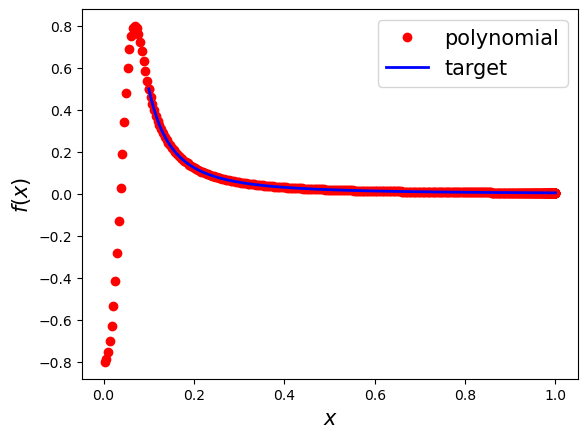

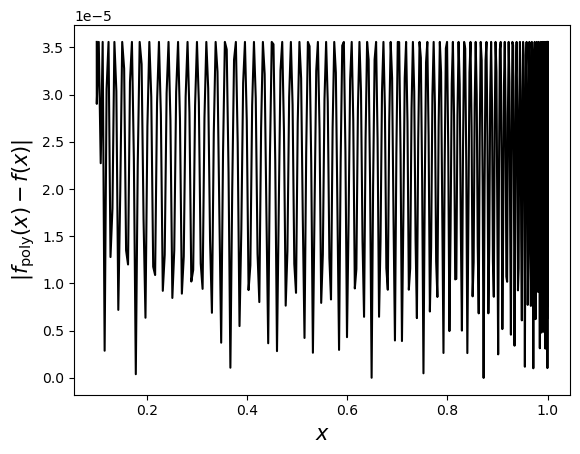

In [2]:
from qsppack.utils import cvx_poly_coef

coef_full = cvx_poly_coef(targ, deg, opts)
coef = coef_full[parity::2]

## Solving the phase factors and verifying

We can again use Newton's method to find the phase factors and verify the solution.

iter err          
   1  +1.4304e-01
   2  +1.0329e-02
   3  +8.1428e-05
   4  +5.3832e-09
Stop criteria satisfied.
The residual error is
6.661338147750939e-15


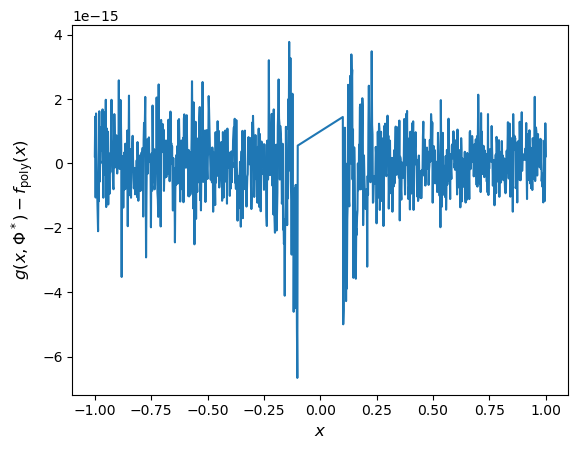

In [3]:
opts.update({
    'maxiter': 100,
    'criteria': 1e-14,
    'useReal': False,
    'targetPre': True,
    'method': 'Newton'
})

from qsppack.solver import solve
phi_proc, out = solve(coef, parity, opts)

from qsppack.utils import chebyshev_to_func, get_entry
import matplotlib.pyplot as plt

xlist1 = np.linspace(-1,-1/kappa,500)
xlist2 = np.linspace(1/kappa,1,500)
xlist = np.concatenate([xlist1, xlist2])
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).

2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.